In [320]:
from pathlib import Path
from mpi4py import MPI
from petsc4py.PETSc import ScalarType 

import numpy as np
from petsc4py import PETSc
import matplotlib.pyplot as plt
import seaborn as sns


import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem import petsc
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import meshtags
from dolfinx.fem.petsc import (
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc)


In [321]:
# Embankment properties
Load = 100 # load (kPa)
Base = 10 # embankment width (m)
 
nx = 50

name = ["Made ground", "Soft clay", "Firm clay"]
depths = [1, 2, 4, 5]
k = [2e-7,2e-7, 2e-7, 2e-7] # this is Cv 
Mv = [5e-4, 10e-4, 5e-4, 5e-4]

T = (60*60*24) * 365 # final time (days)
time_steps = 100
dt = T / time_steps  

H = max(depths)
z = np.linspace(0, H, nx, dtype= np.float64)# kept as small and not zero to prevent error




# these are made specailly for a FEniCSx Function and not to be used normally
def Boussinesq(z):  # no input paramters required as this is only recalled under the same paramter each time
    """
    Boussinesq initial condition (strip load, centreline) for Terzaghi consolidation.
    Assumptions:
    - uniform embankment pressure q
    - embankment width B
    - 1D column at centreline
    - elastic stress distribution used only for initial condition
    """
    z = np.maximum(z,1e-12)
    u = (2.0 * Load / np.pi) * (np.arctan(Base / (2.0 * z)) + (Base * z) / (2.0 * z**2 + 0.5 * Base**2))
    return u


def uniform(z):
    u = np.full(z.shape[1], Load, dtype=np.float64)   # load everywhere
    u[np.isclose(z[0], 0.0)] = 0.0                    # top boundary x=0 -> 0
    return u


In [ ]:
msh = mesh.create_interval(
    comm=MPI.COMM_WORLD,
    nx=nx,
    points=[0.0, H],
)

tdim = msh.topology.dim
msh.topology.create_connectivity(tdim, 0)

conn = msh.topology.connectivity(tdim, 0)

In [323]:

num_cells_local = msh.topology.index_map(tdim).size_local
cells = np.arange(num_cells_local, dtype= np.int32) 
cell_verts = conn.array.reshape(num_cells_local, 2)

x = msh.geometry.x[:,0] # z geomtry only 
midpoints = 0.5 * (x[cell_verts[:, 0]] + x[cell_verts[:, 1]]) # cell_verts the 0 or 1 talks about the left and right respectively

cell_markers = np.zeros(num_cells_local, dtype=np.int32)
z_interface = [0.0] + depths # adding first zero interface 

DG0 = fem.functionspace(msh, ("DG", 0))

for i in range(len(k)):
    z0 = z_interface[i]
    z1 = z_interface[i+1]
    mask = (midpoints >= z0) & (midpoints < z1)  # returning on true bo0lean
    cell_markers[mask] = i + 1

# include bottom endpoint safely in last layer
cell_markers[midpoints >= z[-2]] = len(k)


kappa = fem.Function(DG0)

dofmap = DG0.dofmap
kappa.x.array[:] = 0.0

for cell in range(num_cells_local):
    lid = cell_markers[cell]
    if lid ==0 :
        continue
    dof = dofmap.cell_dofs(cell)[0]
    kappa.x.array[dof] = k[lid - 1]


# check 
kappa.x.scatter_forward()
for c in range(min(10, num_cells_local)):
    dof = DG0.dofmap.cell_dofs(c)[0]
    print("cell", c, "layer", cell_markers[c], "kappa", kappa.x.array[dof])

cell 0 layer 1 kappa 2e-07
cell 1 layer 1 kappa 2e-07
cell 2 layer 1 kappa 2e-07
cell 3 layer 1 kappa 2e-07
cell 4 layer 1 kappa 2e-07
cell 5 layer 1 kappa 2e-07
cell 6 layer 1 kappa 2e-07
cell 7 layer 1 kappa 2e-07
cell 8 layer 1 kappa 2e-07
cell 9 layer 1 kappa 2e-07


In [324]:
V = fem.functionspace(msh, ("Lagrange", 1))

# Solution functions
u_n = fem.Function(V)

# Initial condition
u_n.interpolate(uniform)

fdim = msh.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(
    msh, fdim,
    marker=lambda x: np.isclose(x[0], 0.0)
)

dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(PETSc.ScalarType(0), dofs, V)

In [325]:
V = fem.functionspace(msh, ("Lagrange", 1))

# Solution functions
u_n = fem.Function(V)

initial_condition = lambda x: Boussinesq(x[0])

# Initial condition
u_n.interpolate(uniform)

fdim = msh.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(
    msh, fdim,
    marker=lambda x: np.isclose(x[0], 0.0)
)

dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(PETSc.ScalarType(0), dofs, V)


In [326]:
uh = fem.Function(V)
uh.name = "uh"
uh.interpolate(uniform)
# xdmf.write_function(uh,t)

# varational form
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
 # PETSc make sure the background stuff doesnt explode
a = (u * v) * ufl.dx + dt * kappa  * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = (u_n) * v * ufl.dx
bilinear_form = fem.form(a)
linear_form = fem.form(L)

A = assemble_matrix(bilinear_form, bcs = [bc])
A.assemble()
b = petsc.create_vector(fem.extract_function_spaces(linear_form))


In [327]:
# creating linear solver 
solver = PETSc.KSP().create(msh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

In [328]:
u_hist = np.zeros((time_steps + 1, uh.x.array.size), dtype=float)
u_hist[0, :] = uh.x.array.copy()   # initial state
x = V.mesh.geometry.x[:, 0].copy()


for i in range(time_steps):
    with b.localForm() as loc_b:
        loc_b.set(0.0)
    assemble_vector(b, linear_form)

    apply_lifting(b ,[bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,
                  mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve
    solver.solve(b, uh.x.petsc_vec)

    # Update time-step solution
    u_n.x.array[:] = uh.x.array
    u_n.x.scatter_forward()

    u_hist[i + 1, :] = uh.x.array.copy()

# xdmf.close()
A.destroy()
b.destroy()
solver.destroy

u0 = u_hist[0, :]                 # initial condition in space
local_dcons = 1 - u_hist / u0[None,:]
local_dcons[:,0] = int(1)

local_dcons

/tmp/ipykernel_5908/1537152639.py:31: RuntimeWarning: invalid value encountered in divide
  local_dcons = 1 - u_hist / u0[None,:]


array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 6.87921817e-01, 4.60731235e-01, ...,
        5.43073431e-09, 4.38617775e-09, 4.05592004e-09],
       [1.00000000e+00, 8.09006395e-01, 6.35427669e-01, ...,
        5.89805506e-08, 4.84820423e-08, 4.51452595e-08],
       ...,
       [1.00000000e+00, 9.78041988e-01, 9.56107147e-01, ...,
        3.10351388e-01, 3.09352694e-01, 3.09019711e-01],
       [1.00000000e+00, 9.78186769e-01, 9.56396486e-01, ...,
        3.14525084e-01, 3.13531311e-01, 3.13199967e-01],
       [1.00000000e+00, 9.78330179e-01, 9.56683091e-01, ...,
        3.18677900e-01, 3.17689084e-01, 3.17359391e-01]], shape=(101, 51))

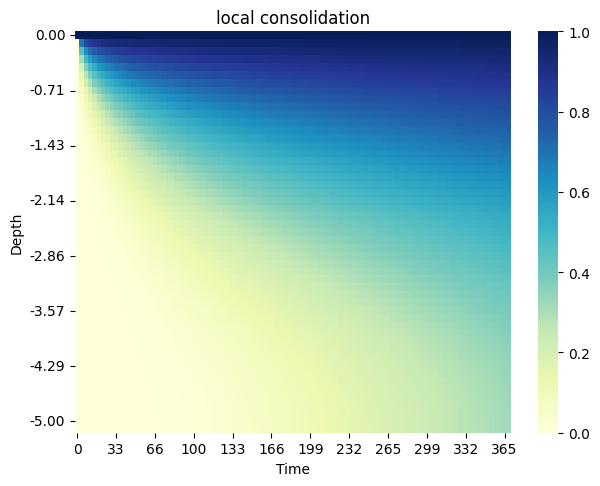

In [329]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

time = np.linspace(0,T,time_steps)/(60*60*24)
depth = np.linspace(0, -abs(H), nx)


kx = max(1, len(time)//11)    # ~8 labels across, auto
ky = max(1, len(depth)//7)  # ~10 labels down, auto 
local_dcons = local_dcons.T 

ax = sns.heatmap(local_dcons, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.0f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.2f}" for i in range(0, len(depth), ky)],
                   rotation=0)


ax.set_xlabel("Time")
ax.set_ylabel("Depth")
plt.tight_layout()
plt.title("local consolidation")
plt.show()


In [330]:
#
def initial_condition(x):
    u = np.full(x.shape[0], Load, dtype=np.float64)   # shape (npts,)
    u[0] = 0.0                    # enforce u=0 at z=0
    return u


A = initial_condition(z)

gfg = np.digitize(z,depths)
Mv = np.asarray(Mv)[gfg - 1]

settlement = A * Mv * (H / nx)

In [331]:
for columns in local_dcons.T:
    pass

A = pd.DataFrame(local_dcons.T, dtype = float)

A

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.0,0.687922,0.460731,0.308572,0.206664,0.138412,0.092700,0.062086,0.041581,0.027849,...,7.485161e-08,5.017666e-08,3.367309e-08,2.265327e-08,1.532258e-08,1.048721e-08,7.359698e-09,5.430734e-09,4.386178e-09,4.055920e-09
2,1.0,0.809006,0.635428,0.488262,0.368996,0.275252,0.203181,0.148692,0.108033,0.078012,...,6.964931e-07,4.772189e-07,3.272677e-07,2.249802e-07,1.555419e-07,1.088710e-07,7.817576e-08,5.898055e-08,4.848204e-08,4.514526e-08
3,1.0,0.853414,0.713588,0.585773,0.473080,0.376645,0.296134,0.230284,0.177346,0.135406,...,3.427737e-06,2.397584e-06,1.678285e-06,1.177709e-06,8.313949e-07,5.945274e-07,4.363165e-07,3.361176e-07,2.808150e-07,2.631539e-07
4,1.0,0.876994,0.757644,0.645143,0.541900,0.449424,0.368367,0.298676,0.239772,0.190736,...,1.189513e-05,8.483530e-06,6.054601e-06,4.332429e-06,3.119823e-06,2.276922e-06,1.705869e-06,1.339990e-06,1.136375e-06,1.071069e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.0,0.977748,0.955520,0.933339,0.911229,0.889213,0.867314,0.845556,0.823961,0.802552,...,3.276941e-01,3.220302e-01,3.170225e-01,3.126747e-01,3.089902e-01,3.059718e-01,3.036218e-01,3.019420e-01,3.009336e-01,3.005973e-01
97,1.0,0.977896,0.955815,0.933781,0.911817,0.889946,0.868192,0.846576,0.825123,0.803853,...,3.317836e-01,3.261477e-01,3.211645e-01,3.168379e-01,3.131712e-01,3.101674e-01,3.078287e-01,3.061570e-01,3.051534e-01,3.048188e-01
98,1.0,0.978042,0.956107,0.934219,0.912399,0.890673,0.869061,0.847587,0.826273,0.805142,...,3.358516e-01,3.302438e-01,3.252853e-01,3.209800e-01,3.173314e-01,3.143423e-01,3.120150e-01,3.103514e-01,3.093527e-01,3.090197e-01
99,1.0,0.978187,0.956396,0.934652,0.912976,0.891392,0.869922,0.848588,0.827413,0.806419,...,3.398980e-01,3.343184e-01,3.293848e-01,3.251010e-01,3.214706e-01,3.184963e-01,3.161805e-01,3.145251e-01,3.135313e-01,3.132000e-01
